In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [208]:
engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1" )

In [209]:
engagement.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [410]:
engagement.shape

(207917, 2)

In [210]:
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [600]:
#QUESTION ???????????????????????????????????
#should I here seperate a part of data as validation and continue with the rest for feature engineering and analysis

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,adoption_date,user_avtive_period
object_id,,,,,,,,,,,
3861,2012-05-31 00:43:27,ORG_INVITE,2012-06-03 00:43:27,0,0,115,3861.0,yahoo,0,NaN,0.0
11430,2012-05-31 01:42:31,ORG_INVITE,2012-06-01 01:42:31,0,0,239,5677.0,hotmail,0,NaN,0.0
7170,2012-05-31 06:23:51,ORG_INVITE,2012-08-20 06:23:51,0,0,145,7170.0,hotmail,0,NaN,79.0
10012,2012-05-31 08:20:06,ORG_INVITE,2012-05-31 08:20:06,0,1,225,7104.0,hotmail,0,NaN,0.0
11999,2012-05-31 11:55:59,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,iuxiw,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6945,2014-05-30 23:10:35,SIGNUP,2014-05-31 23:10:35,0,0,5,NaN,cuvox,0,NaN,0.0
9688,2014-05-30 23:12:01,GUEST_INVITE,2014-06-01 23:12:01,0,0,93,7296.0,yahoo,0,NaN,0.0
10164,2014-05-30 23:27:30,GUEST_INVITE,2014-05-30 23:27:30,0,0,302,5383.0,jourrapide,0,NaN,0.0


In [249]:
# seperating domain info
users['domain'] = users.email.str.extract('@([a-zA-Z0-9]+)\..+$')[0]

In [250]:
#drop columns with personal information
users.drop(['name', 'email'], axis=1, inplace=True)
#turn date columns into datetime 
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
#setting user_id as index for both dataframes 
users.set_index('object_id', inplace=True)
engagement.set_index('user_id', inplace=True)

In [403]:
users.creation_time.dt.year.unique()

array([2014, 2013, 2012])

In [412]:
# there are 12000 unique users 
users.index.nunique()

12000

### Finding taget method 1

In [ ]:
#using the engagement to find the users for whom the difference between their each log event and two after that is less
# or equal to 7 days
target = pd.DataFrame()
target['days_between_first_third'] = engagement.groupby('user_id')['time_stamp'].diff(2)/np.timedelta64(1,'D')
target.head()

In [439]:
target.head(3)

,days_between_first_third
user_id,
1,NaN
2,NaN
2,NaN


In [440]:
#now for each user I only keep the smallest difference between logs and define a new column adoption_stat and 
#place 1 for users that have 
target_results = pd.DataFrame()
target_results['adopted'] = target.groupby('user_id').min().apply(lambda x: 1 if x['days_between_first_third']<=7 else 0, axis=1)
target_results.head(2)

,adopted
user_id,
1,0
2,1


In [441]:
#merging the 
results = pd.merge(users, target_results, right_index=True, left_index=True, how='left')
results.adopted_y = results.adopted_y.fillna(0).astype(int)
results.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted_x,adoption_date,user_avtive_period,adopted_y
object_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo,0,NaN,0.0,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr,1,2014-02-09 03:45:04,136.0,1
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,gustr,0,NaN,0.0,0
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,yahoo,0,NaN,0.0,0
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,yahoo,0,NaN,0.0,0


### Finding taget method 2

In [252]:
#defining target column
def get_adopted_user_status(df, df2):
    df2['adopted']=0
    df2['adoption_date'] = np.nan
    for user_id, temp_df in df.groupby('user_id'):
        if temp_df.shape[0]>2:
            temp_df = temp_df.sort_values(by='time_stamp')
            a_week = pd.to_timedelta(7,unit='D')
            for i in range(temp_df.shape[0]-2):
                third_time = i+2
                if temp_df.iloc[third_time].time_stamp -temp_df.iloc[i].time_stamp <= a_week:
                    df2.loc[user_id,'adopted']=1
                    df2.loc[user_id,'adoption_date'] = temp_df.iloc[third_time]['time_stamp']
                    break
    return df2

In [253]:
users_with_target = get_adopted_user_status(engagement, users)

In [442]:
users_with_target.head(2)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,adoption_date,user_avtive_period
object_id,,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo,0,NaN,0.0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr,1,2014-02-09 03:45:04,136.0


In [255]:
not_missing_adaoption = users_with_target[users_with_target.adoption_date.notnull()]
not_missing_adaoption.loc[:,'adoption_date'] = pd.to_datetime(not_missing_adaoption['adoption_date'])
not_missing_adaoption['days_until_adoption']=(not_missing_adaoption.adoption_date - not_missing_adaoption.creation_time).astype('timedelta64[24h]').astype('int')
not_missing_adaoption.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,adoption_date,days_until_adoption
object_id,,,,,,,,,,,
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr,1,2014-02-09 03:45:04,86
10,2013-01-16 22:08:03,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,gustr,1,2013-02-06 22:08:03,21
20,2014-03-06 11:46:38,SIGNUP,2014-05-29 11:46:38,0,0,58,NaN,uhzdq,1,2014-03-13 11:46:38,7
33,2014-03-11 06:29:09,GUEST_INVITE,2014-05-31 06:29:09,0,0,401,79.0,cuvox,1,2014-03-23 06:29:09,12
42,2012-11-11 19:05:07,SIGNUP,2014-05-25 19:05:07,1,0,235,NaN,cuvox,1,2012-12-25 19:05:07,44


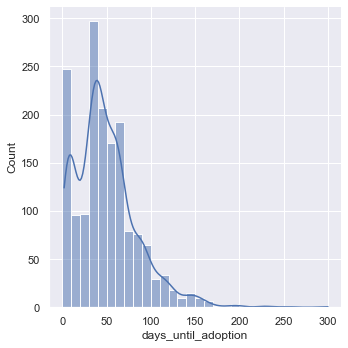

In [57]:
#user adoption is most often in the first week or after a month or two after creation time after that user adoption drops.
sns.displot(not_missing_adaoption.days_until_adoption, kde=True, bins=np.arange(0,300,10))

In [ ]:
#Questions
"""
Here the goal is to predict if the user becomes adopted (logged into the product on three  separate days in at
least one seven day period). Should I remove the log information for users after adoption from the user engagement
data? because if I'm trying to create a feature like average time between logs or number of logs per week that
value would be different If I consider the log activity of the user after adoption as well. I think the question
in general is a little unclear for me. For example the question could have been use the first week of data for
each user and find out If the user becomes adopted by the end of the month. In this example a user can become 
adopted after the third day and another user can become adopted after months
"""

In [ ]:
#????????????????????????
# corrected_log = pd.merge(engagement, not_missing_adaoption, how = 'left', right_index=True, left_index=True).reset_index()
# corrected_log.head()

In [443]:
#number of days between users first login and last login time
user_avtive_period = engagement.groupby('user_id')['time_stamp'].agg([min,max])
(user_avtive_period['max'] - user_avtive_period['min']).astype('timedelta64[24h]').astype(int)

user_id
1          0
2        136
3          0
4          0
5          0
        ... 
11996      0
11997      0
11998      0
11999      0
12000      0
Length: 8823, dtype: int64

In [444]:
#adding user_active_period to the data 
users_with_target['user_avtive_period'] = (user_avtive_period['max'] - user_avtive_period['min']).astype('timedelta64[24h]').astype(int)

In [304]:
#finding mean and max time between each user's log event
diff_between_logs = engagement.groupby('user_id')['time_stamp'].diff().fillna(pd.Timedelta(seconds=0))/np.timedelta64(1,'D')
diff_between_logs.head()

user_id
1     0.0
2     0.0
2    14.0
2    10.0
2    16.0
Name: time_stamp, dtype: float64

In [452]:
engagement_stat_by_user = diff_between_logs.groupby('user_id').agg([np.mean, max])
engagement_stat_by_user.columns = ['mean_time_between_logs', 'max_time_between_logs']
engagement_stat_by_user.mean_time_between_logs = engagement_stat_by_user.mean_time_between_logs.round()
engagement_stat_by_user = engagement_stat_by_user.fillna(0)
engagement_stat_by_user.head()

,mean_time_between_logs,max_time_between_logs
user_id,,
1,0.0,0.0
2,10.0,26.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


In [447]:
users_with_target = pd.merge(users_with_target, engagement_stat_by_user, right_index=True, left_index=True, how='left')

In [449]:
users_with_target.head(3)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,adoption_date,user_avtive_period,mean_time_between_logs,max_time_between_logs
object_id,,,,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,yahoo,0,NaN,0.0,0.0,0.0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,gustr,1,2014-02-09 03:45:04,136.0,10.0,26.0
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,gustr,0,NaN,0.0,0.0,0.0


In [455]:
# users_with_target.max_time_between_logs = users_with_target.max_time_between_logs.fillna(0)
# users_with_target.mean_time_between_logs = users_with_target.mean_time_between_logs.fillna(0)
# users_with_target.user_avtive_period = users_with_target.user_avtive_period.fillna(0)
# users_with_target.drop(['adoption_date'], axis=1, inplace=True)
users_with_target.isna().any()

creation_time                 False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
domain                        False
adopted                       False
user_avtive_period            False
mean_time_between_logs        False
max_time_between_logs         False
dtype: bool

In [456]:
users_with_target.adopted.value_counts()

0    10344
1     1656
Name: adopted, dtype: int64

In [60]:
#looking for missing values
users_with_target.isna().sum()/users_with_target.shape[0]

creation_time                 0.00000
creation_source               0.00000
last_session_creation_time    0.26475
opted_in_to_mailing_list      0.00000
enabled_for_marketing_drip    0.00000
org_id                        0.00000
invited_by_user_id            0.46525
adopted                       0.00000
dtype: float64

In [457]:
#there is also no log information for these users so we can't define the target value for them (they are all zero but that migh not be true because we don't have the log info).
users_with_target[users_with_target.last_session_creation_time.isna()]

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,user_avtive_period,mean_time_between_logs,max_time_between_logs
object_id,,,,,,,,,,,,
8,2013-07-31 05:34:02,PERSONAL_PROJECTS,NaT,1,1,74,NaN,yahoo,0,0.0,0.0,0.0
9,2013-11-05 04:04:24,PERSONAL_PROJECTS,NaT,0,0,302,NaN,hotmail,0,0.0,0.0,0.0
12,2014-04-17 23:48:38,ORG_INVITE,NaT,0,0,130,9270.0,cuvox,0,0.0,0.0,0.0
15,2013-07-16 21:33:54,PERSONAL_PROJECTS,NaT,0,0,175,NaN,hotmail,0,0.0,0.0,0.0
16,2013-02-11 10:09:50,PERSONAL_PROJECTS,NaT,0,0,211,NaN,hotmail,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11976,2013-12-25 22:01:41,PERSONAL_PROJECTS,NaT,0,0,248,NaN,hotmail,0,0.0,0.0,0.0
11978,2014-04-23 16:28:06,PERSONAL_PROJECTS,NaT,1,0,29,NaN,gustr,0,0.0,0.0,0.0
11985,2013-07-08 17:23:26,PERSONAL_PROJECTS,NaT,0,0,74,NaN,cuvox,0,0.0,0.0,0.0


In [458]:
#Drop users with missing log and target values.
users_with_target.dropna(subset=['last_session_creation_time'], axis=0, inplace=True)

In [459]:
users_with_target.isna().sum()

creation_time                    0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
domain                           0
adopted                          0
user_avtive_period               0
mean_time_between_logs           0
max_time_between_logs            0
dtype: int64

In [460]:
users_with_target[users_with_target.invited_by_user_id.isna()]

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,user_avtive_period,mean_time_between_logs,max_time_between_logs
object_id,,,,,,,,,,,,
7,2012-12-16 13:24:32,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,jourrapide,0,0.0,0.0,0.0
11,2013-12-26 03:55:54,SIGNUP,2013-12-27 03:55:54,0,0,69,NaN,gustr,0,0.0,0.0,0.0
14,2012-10-11 16:14:33,SIGNUP,2012-10-12 16:14:33,0,0,0,NaN,gmail,0,0.0,0.0,0.0
19,2013-05-24 14:56:36,SIGNUP,2013-05-30 14:56:36,1,0,0,NaN,gmail,0,5.0,2.0,5.0
20,2014-03-06 11:46:38,SIGNUP,2014-05-29 11:46:38,0,0,58,NaN,uhzdq,1,79.0,11.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11992,2014-04-09 19:39:56,PERSONAL_PROJECTS,2014-04-11 19:39:56,0,0,129,NaN,yahoo,0,0.0,0.0,0.0
11995,2013-10-21 13:33:17,PERSONAL_PROJECTS,2013-10-22 13:33:17,0,0,0,NaN,gmail,0,0.0,0.0,0.0
11997,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,gmail,0,0.0,0.0,0.0


In [257]:
users_with_target.org_id.nunique()

417

users who signed up are not invited by any other user so they have a missing value in invited_by_user_id column. fill those with 0

In [461]:
users_with_target.invited_by_user_id.fillna(0,inplace=True)
users_with_target.invited_by_user_id = users_with_target.invited_by_user_id.astype(int)

In [462]:
users_with_target.isna().sum()

creation_time                 0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
domain                        0
adopted                       0
user_avtive_period            0
mean_time_between_logs        0
max_time_between_logs         0
dtype: int64

In [463]:
def count_plot_with_pct(df, x, hue_col, class_order, hue_order):
    df = df.dropna()
    order = class_order 
    hue_order = hue_order
    bar_order = product(hue_order, class_order)

    catp = sns.catplot(data=df, kind='count', 
                       x=x, hue=hue_col,
                       order = order, 
                       hue_order = hue_order,
                       height=5,aspect=2,palette='coolwarm_r')


    spots = zip(catp.ax.patches, bar_order)
    for spot in spots:
        class_total = (df[df[x]==spot[1][1]]).shape[0]
        class_hue_total = (df[(df[x]==spot[1][1]) & (df[hue_col]==spot[1][0])]).shape[0]
        height = spot[0].get_height() 
        x_pos = spot[0].get_x()+0.1
        catp.ax.text(x_pos, height+20, '{:1.2f}'.format(class_hue_total/class_total))



In [465]:
# It seems that creation source might have a slight effect on the outcome.

In [579]:
users_with_target

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,user_avtive_period,mean_time_between_logs,max_time_between_logs,login_count_per_user
object_id,,,,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,yahoo,0,0.0,0.0,0.0,1
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,gustr,1,136.0,10.0,26.0,14
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,gustr,0,0.0,0.0,0.0,1
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,yahoo,0,0.0,0.0,0.0,1
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,yahoo,0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,2013-09-06 06:14:15,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263,gustr,0,0.0,0.0,0.0,1
11997,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,0,gmail,0,0.0,0.0,0.0,1
11998,2014-04-27 12:45:16,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074,cuvox,0,0.0,0.0,0.0,1


In [553]:
users.groupby('creation_source')['adopted'].mean()

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted, dtype: float64

In [578]:
# how many unique domains are there
users_with_target.domain.nunique()

812

In [596]:
#for modeling we can only keep the top 7 domains and put the rest in other categories 
users_with_target.groupby('domain')['adopted'].agg([np.mean, len]).sort_values(by='len', ascending=False)[:6].index

Index(['gmail', 'yahoo', 'jourrapide', 'gustr', 'cuvox', 'hotmail'], dtype='object', name='domain')

In [598]:
users_with_target.domain = users_with_target.domain.apply(lambda x: x if x in ['gmail', 'yahoo', 'jourrapide', 'gustr', 'cuvox', 'hotmail'] else 'other')

<AxesSubplot:xlabel='creation_source', ylabel='adopted'>

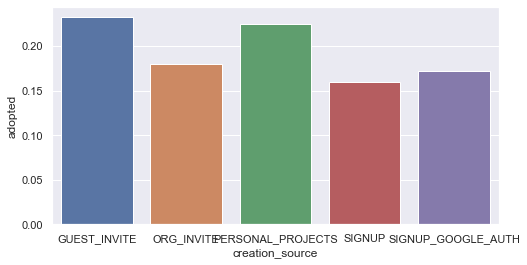

In [561]:
plt.figure(figsize=(8,4))
sns.barplot(x=users_with_target.groupby('creation_source')['adopted'].mean().index, y = users_with_target.groupby('creation_source')['adopted'].mean())

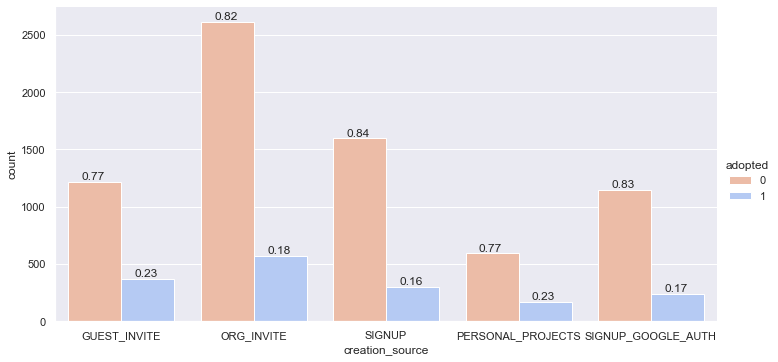

In [466]:
count_plot_with_pct(df=users_with_target, x='creation_source', hue_col='adopted', class_order=['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS','SIGNUP_GOOGLE_AUTH'], hue_order=[0,1])

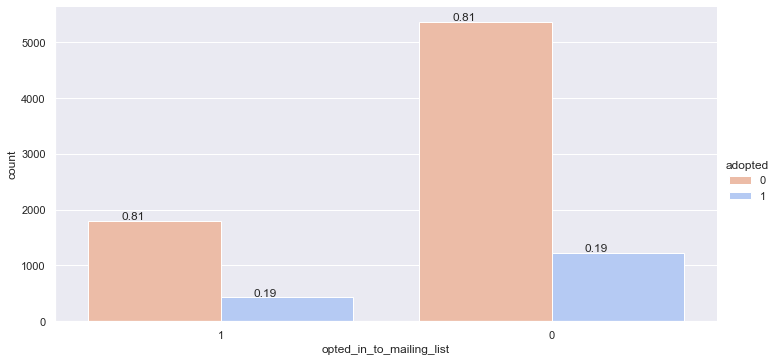

In [467]:
# opted_in_to_mailing_list column has no affect on the target outcome 
count_plot_with_pct(df=users_with_target, x='opted_in_to_mailing_list', hue_col='adopted', class_order=users_with_target.opted_in_to_mailing_list.unique(), hue_order=[0,1])

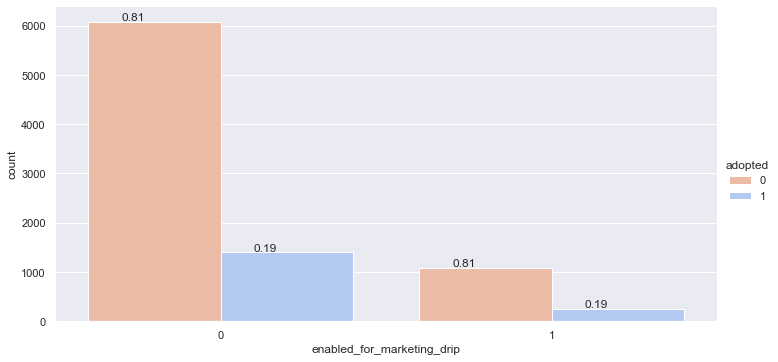

In [468]:
# enabled_for_marketing_drip column has no affect on the target outcome 
count_plot_with_pct(df=users_with_target, x='enabled_for_marketing_drip', hue_col='adopted', class_order=users_with_target.enabled_for_marketing_drip.unique(), hue_order=[0,1])

In [504]:
org_id_effect = users_with_target.groupby(['org_id'])['adopted'].agg([np.mean, len])
org_id_effect.columns = ['mean_adopted_by_org', 'num_users_by_org']
org_id_effect.sort_values(by='mean_adopted_by_org', ascending=False)[:20]

,mean_adopted_by_org,num_users_by_org
org_id,,
387,0.636364,11
235,0.600000,10
273,0.555556,9
289,0.545455,11
400,0.500000,6
248,0.500000,12
306,0.500000,12
117,0.500000,16
399,0.500000,10


In [526]:
# org_id_effect[(org_id_effect.num_users_by_org>=20) & (org_id_effect.mean_adopted_by_org>=0.4)].sort_values(by='mean_adopted_by_org', ascending=False)

In [75]:
# Some organizations have high adaption rates while others don't

Text(0, 0.5, 'percent adopted (%)')

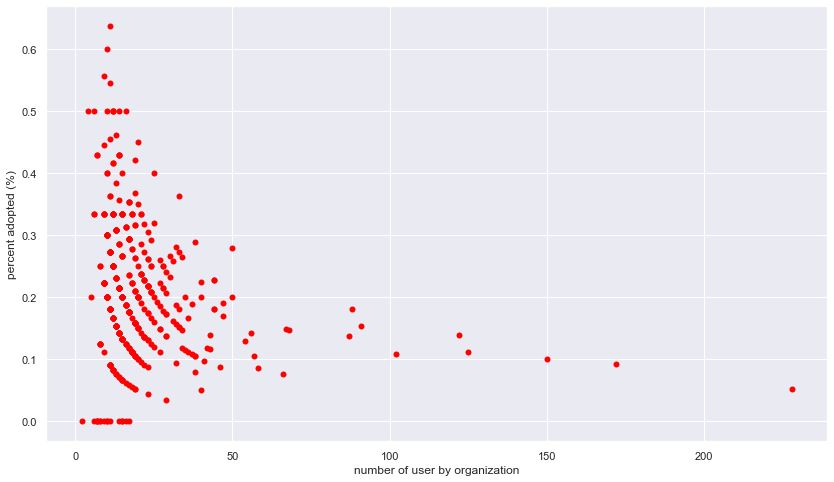

In [599]:
plt.figure(figsize=(14,8))
plt.scatter(x= org_id_effect.num_users_by_org, y = org_id_effect.mean_adopted_by_org,linewidth=0,color='red' )
plt.xlabel('number of user by organization')
plt.ylabel('percent adopted (%)')

Text(0.5, 8.95999999999998, 'percent adopted (%)')

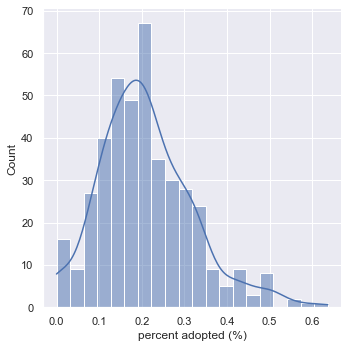

In [533]:
sns.displot(org_id_effect.mean_adopted_by_org, kde=True, bins=20)
plt.xlabel('percent adopted (%)')

In [688]:
users_with_target.head(2)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,user_avtive_period,mean_time_between_logs,max_time_between_logs,login_count_per_user
object_id,,,,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,yahoo,0,0.0,0.0,0.0,1
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,gustr,1,136.0,10.0,26.0,14


<AxesSubplot:xlabel='adopted', ylabel='user_avtive_period'>

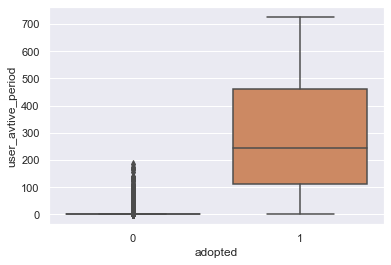

In [686]:
sns.boxplot(data=users_with_target, x='adopted', y='user_avtive_period')

<AxesSubplot:xlabel='adopted', ylabel='mean_time_between_logs'>

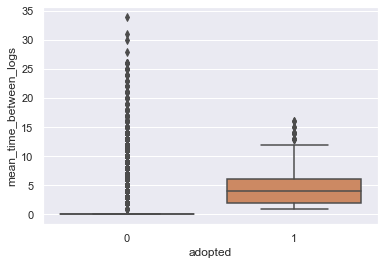

In [689]:
sns.boxplot(data=users_with_target, x='adopted', y='mean_time_between_logs')

<AxesSubplot:xlabel='adopted', ylabel='max_time_between_logs'>

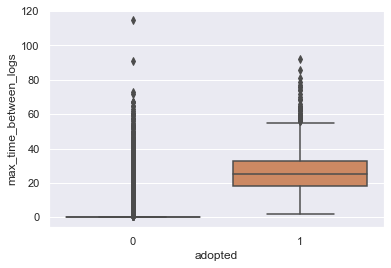

In [690]:
sns.boxplot(data=users_with_target, x='adopted', y='max_time_between_logs')

<AxesSubplot:xlabel='adopted', ylabel='login_count_per_user'>

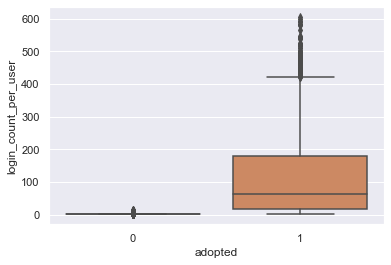

In [691]:
sns.boxplot(data=users_with_target, x='adopted', y='login_count_per_user')

In [604]:
# I keep the the organization that have more than 15 users and more than 30% of users adopted and put the rest in other_org

In [82]:
# df['org_id_effect'] = pd.cut(df.org_id_effect, [-np.inf,40, np.inf], labels=['low', 'high'])

In [83]:
# df.org_id_effect.value_counts()

In [84]:
engagement.head()

,time_stamp,visited
user_id,,
1,2014-04-22 03:53:30,1
2,2013-11-15 03:45:04,1
2,2013-11-29 03:45:04,1
2,2013-12-09 03:45:04,1
2,2013-12-25 03:45:04,1


In [537]:
# how many time each user id logged in?
engagement_count_per_user = engagement.groupby(engagement.index).sum().rename(columns={'visited': 'login_count_per_user'})
users_with_target = pd.merge(users_with_target, engagement_count_per_user, right_index=True, left_index=True, how='left')

Text(0.5, 1.0, 'log plot')

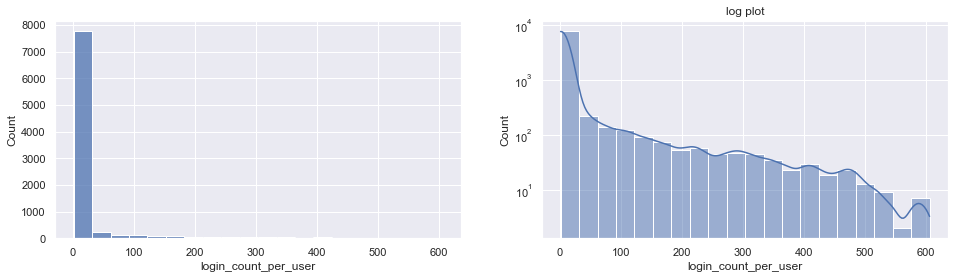

In [539]:
# it appears a lot of users don't interact with the product after the first day
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
sns.histplot(users_with_target.login_count_per_user, bins=20,ax=ax1)
sns.histplot(users_with_target.login_count_per_user,  bins=20,kde=True, ax=ax2)
ax2.set_yscale('log')
ax2.set_title('log plot')

<AxesSubplot:ylabel='log_count_per_user'>

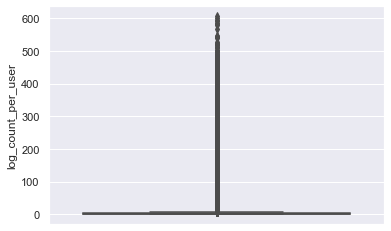

In [87]:
sns.boxplot(y=engagement_count_per_user.log_count_per_user)

In [88]:
# A lot of users logged in only one time

In [540]:
engagement['hour'] = engagement.time_stamp.dt.hour
engagement['day_of_week'] = engagement.time_stamp.dt.day_name()
engagement['month'] = engagement.time_stamp.dt.month_name()

In [639]:
engagement

,time_stamp,visited,hour,day_of_week,month
user_id,,,,,
1,2014-04-22 03:53:30,1,3,Tuesday,April
2,2013-11-15 03:45:04,1,3,Friday,November
2,2013-11-29 03:45:04,1,3,Friday,November
2,2013-12-09 03:45:04,1,3,Monday,December
2,2013-12-25 03:45:04,1,3,Wednesday,December
...,...,...,...,...,...
11996,2013-09-06 06:14:15,1,6,Friday,September
11997,2013-01-15 18:28:37,1,18,Tuesday,January
11998,2014-04-27 12:45:16,1,12,Sunday,April


In [640]:
def summerize_log_info(df=engagement):
    summary_log = pd.DataFrame()
    for col in df.columns[2:]:
        temp_df = df.groupby(['user_id',col])['visited'].aggregate('sum').unstack()
        summary_log = pd.concat([summary_log,temp_df], axis=1)
        summary_log.fillna(0, inplace=True)
        summary_log = summary_log.astype(int)
    return summary_log
summerize_log = summerize_log_info()
summerize_log.head(2)

,0,1,2,3,4,5,6,7,8,9,...,December,February,January,July,June,March,May,November,October,September
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,14,0,0,0,0,0,0,...,3,5,1,0,0,3,0,2,0,0


In [641]:
summerize_log.index.is_unique

True

In [642]:
df = pd.merge(users_with_target, summerize_log, right_index=True, left_index=True, how='left')
df.head(2)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,user_avtive_period,...,December,February,January,July,June,March,May,November,October,September
object_id,,,,,,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,yahoo,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,gustr,1,136.0,...,3,5,1,0,0,3,0,2,0,0


In [643]:
df_grouped = df.groupby('adopted').sum().T
df_grouped['percent_adopted'] = df_grouped.apply(lambda x: x[1]*100/(x[0]+x[1]), axis=1)
df_grouped.head()

adopted,0,1,percent_adopted
opted_in_to_mailing_list,1797.0,429.0,19.272237
enabled_for_marketing_drip,1084.0,257.0,19.164802
org_id,988557.0,269358.0,21.413053
invited_by_user_id,22930667.0,5632179.0,19.718550
user_avtive_period,30828.0,482850.0,93.998575


<AxesSubplot:>

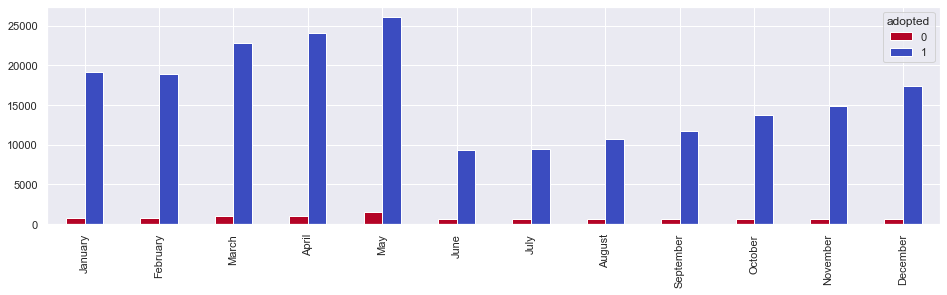

In [644]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_grouped.loc[df_grouped.index.isin(months), [0,1]].loc[months].plot(kind='bar', figsize=(16,4),sort_columns=months, cmap='coolwarm_r')

In [645]:
df_grouped.loc[months].percent_adopted

January      96.074598
February     96.091057
March        95.898191
April        95.731998
May          94.663135
June         93.541937
July         94.096672
August       94.506756
September    94.722741
October      95.261776
November     95.824729
December     96.290752
Name: percent_adopted, dtype: float64

In [646]:
#user adoption is only slightly better from Dec to Feb.

<AxesSubplot:>

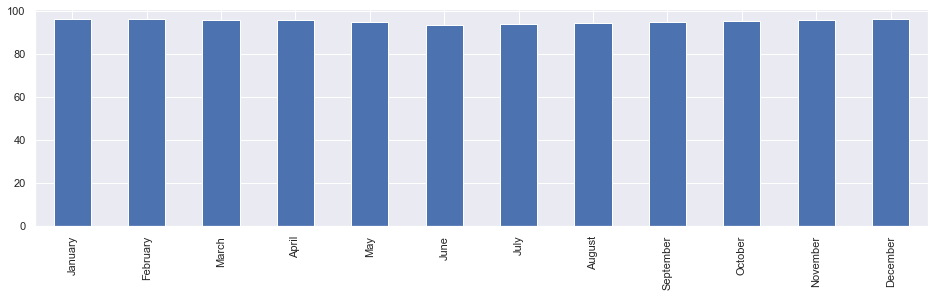

In [647]:
df_grouped.loc[months].percent_adopted.plot(kind='bar', figsize=(16,4))

In [648]:
weekdays =['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday']

<AxesSubplot:>

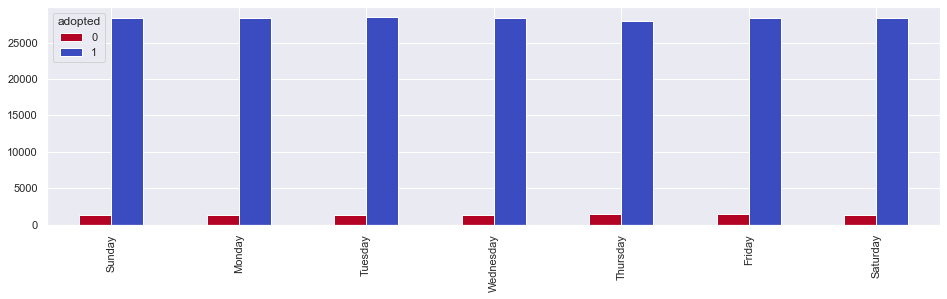

In [649]:
df_grouped.loc[df_grouped.index.isin(weekdays),[0,1]].loc[weekdays].plot(kind='bar', figsize=(16,4), cmap='coolwarm_r')

In [650]:
df_grouped.loc[weekdays].percent_adopted

Sunday       95.492712
Monday       95.489886
Tuesday      95.534515
Wednesday    95.420617
Thursday     95.143983
Friday       95.253952
Saturday     95.374731
Name: percent_adopted, dtype: float64

<AxesSubplot:>

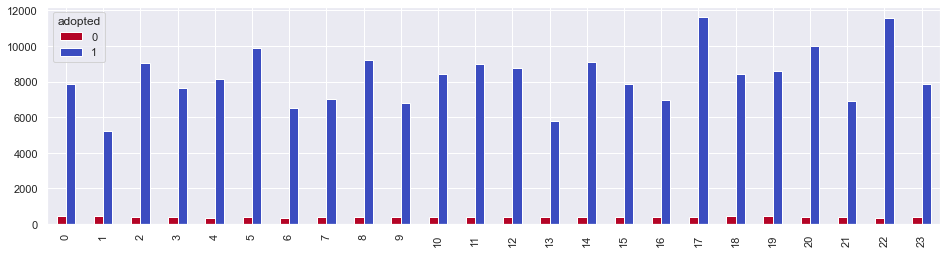

In [651]:
df_grouped.loc[df_grouped.index.isin(range(24)),[0,1]].plot(kind='bar', figsize=(16,4), cmap='coolwarm_r')

<AxesSubplot:>

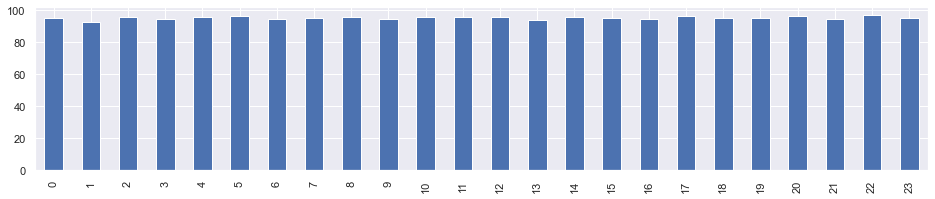

In [652]:
df_grouped.loc[range(24)].percent_adopted.plot(kind='bar', figsize=(16,3))

In [653]:
df_grouped.loc[range(24)].percent_adopted.sort_values()

1     92.418646
13    93.952659
21    94.303970
9     94.359967
16    94.367909
6     94.670346
3     94.780458
0     94.827586
7     94.855828
18    94.888287
15    95.140572
23    95.195924
19    95.256610
2     95.627838
11    95.647547
10    95.678381
12    95.690030
4     95.947220
8     95.970429
14    96.010526
5     96.075002
20    96.154958
17    96.531696
22    97.167591
Name: percent_adopted, dtype: float64

In [654]:
# it doesn't appear that there is a meaningful relation between hour of day and adoption rate

In [745]:
df

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,adopted,user_avtive_period,...,December,February,January,July,June,March,May,November,October,September
object_id,,,,,,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,yahoo,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,gustr,1,136.0,...,3,5,1,0,0,3,0,2,0,0
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,gustr,0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,yahoo,0,0.0,...,0,0,0,0,0,0,1,0,0,0
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,yahoo,0,0.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,2013-09-06 06:14:15,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263,gustr,0,0.0,...,0,0,0,0,0,0,0,0,0,1
11997,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,0,gmail,0,0.0,...,0,0,1,0,0,0,0,0,0,0
11998,2014-04-27 12:45:16,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074,cuvox,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [655]:
df.columns

Index([             'creation_time',            'creation_source',
       'last_session_creation_time',   'opted_in_to_mailing_list',
       'enabled_for_marketing_drip',                     'org_id',
               'invited_by_user_id',                     'domain',
                          'adopted',         'user_avtive_period',
           'mean_time_between_logs',      'max_time_between_logs',
             'login_count_per_user',                            0,
                                  1,                            2,
                                  3,                            4,
                                  5,                            6,
                                  7,                            8,
                                  9,                           10,
                                 11,                           12,
                                 13,                           14,
                                 15,                          

In [659]:
#from EDA we saw that opted_in_to_mailing_list and enabled_for_marketing_drip have no effect on outcome
#so we will drop those columns
X = df.drop(['adopted','creation_time', 'last_session_creation_time', 'invited_by_user_id',
             'opted_in_to_mailing_list', 'enabled_for_marketing_drip'], axis=1)
X = X.drop(np.arange(0,24), axis=1)
X = X.drop(weekdays, axis=1)
# X = X.drop(months, axis=1)
y = df['adopted']

In [660]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [678]:
#now finding the org_id with max use adoption using train dataset and leave other organization in other_org group
X_train['adopted'] = y_train
temp_df = X_train.groupby('org_id')['adopted'].agg([np.mean,len])
good_org_list = temp_df[(temp_df['len']>15) & (temp_df['mean']>0.3)].index
bad_org_list = temp_df[(temp_df['len']>15) & (temp_df['mean']<0.1)].index

def group_orgs(org):
    if org in good_org_list:
        return 'good_org'
    if org in bad_org_list:
        return 'bad_org'
    else:
        return 'other_org'
        
X_train.org_id = X_train.org_id.apply(group_orgs)
X_test.org_id = X_test.org_id.apply(group_orgs)
X_train.drop(['adopted'], axis=1, inplace=True)

In [692]:
y.value_counts()

0    7167
1    1656
Name: adopted, dtype: int64

In [696]:
X_train.isna().any()

creation_source           False
org_id                    False
domain                    False
user_avtive_period        False
mean_time_between_logs    False
max_time_between_logs     False
login_count_per_user      False
April                     False
August                    False
December                  False
February                  False
January                   False
July                      False
June                      False
March                     False
May                       False
November                  False
October                   False
September                 False
dtype: bool

In [683]:
X_train.columns[(X_train.dtypes != object)]

Index(['user_avtive_period', 'mean_time_between_logs', 'max_time_between_logs',
       'login_count_per_user', 'April', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September'],
      dtype='object')

In [684]:
cat_cols = ['creation_source', 'org_id', 'domain']
num_cols = X_train.columns[(X_train.dtypes != object)]
num_cols

Index(['user_avtive_period', 'mean_time_between_logs', 'max_time_between_logs',
       'login_count_per_user', 'April', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September'],
      dtype='object')

In [697]:
def vanilla_models(model):
    transform = ColumnTransformer([('ohe', OneHotEncoder(), cat_cols), ('scale', StandardScaler(), num_cols)])
    pipe = Pipeline([('transform', transform), (f'{model}', model)])
    scoring =['recall', 'accuracy']
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)
    pipe_cv = cross_validate(pipe, X_train, y_train, scoring= scoring, cv = cv)
    return pipe_cv

In [698]:
def get_vanilla_model_results(models):
    results = pd.DataFrame()
    for model in models:
        model_name = f'{model}'.split('(')[0]
        model_result = vanilla_models(model)
        for key, val in model_result.items():
            model_result[key] = val.mean()
        temp_results = pd.DataFrame(model_result, index= [model_name], columns=model_result.keys())
        results = pd.concat([results, temp_results])
    return results        

In [699]:
models = [DummyClassifier(strategy='most_frequent'),LogisticRegression(class_weight='balanced'), KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(class_weight='balanced'), XGBClassifier()]
get_vanilla_model_results(models)

,fit_time,score_time,test_recall,test_accuracy
DummyClassifier,0.013790,0.006510,0.000000,0.814605
LogisticRegression,0.032917,0.004186,0.947607,0.975227
KNeighborsClassifier,0.020018,0.131990,0.834939,0.967131
GaussianNB,0.007347,0.004076,0.970302,0.977979
RandomForestClassifier,0.156182,0.015408,0.938011,0.981218
XGBClassifier,0.163891,0.006153,0.946746,0.981704


In [712]:
#GaussianNB appears to have the best results 
transform = ColumnTransformer([('ohe', OneHotEncoder(), cat_cols), ('scale', StandardScaler(), num_cols)])
pipe_nb = Pipeline([('transform', transform), ('nb', GaussianNB())])
pipe_nb.fit(X_train,y_train)
pred_nb = pipe_nb.predict(X_test)

In [713]:
print(confusion_matrix(y_test, pred_nb))


[[2089   47]
 [  18  493]]


In [714]:
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2136
           1       0.91      0.96      0.94       511

    accuracy                           0.98      2647
   macro avg       0.95      0.97      0.96      2647
weighted avg       0.98      0.98      0.98      2647



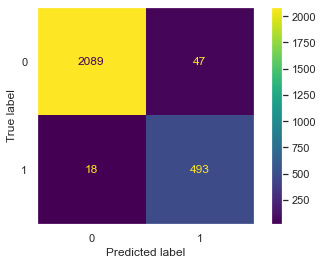

In [715]:
plot_confusion_matrix(pipe_nb, X_test, y_test)
plt.grid(False)

In [735]:
transform = ColumnTransformer([('ohe', OneHotEncoder(), cat_cols), ('scale', StandardScaler(), num_cols)])
pipe_lr = Pipeline([('transform', transform), ('lr', LogisticRegression(class_weight='balanced'))])
pipe_lr.fit(X_train,y_train)
param_grid = {'lr__C':[0.001,0.01,0.1,1],'lr__penalty':['l1','l2']}
cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=21)
lr_grid = GridSearchCV(pipe_lr,cv=cv, param_grid = param_grid, scoring='recall')
lr_grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['creation_source',
                                                                          'org_id',
                                                                          'domain']),
                                                                        ('scale',
                                                                         StandardScaler(),
                                                                         Index(['user_avtive_period', 'mean_time_between_logs', 'max_time_between_logs',
       'login_count_per_user', 'April', 'August', 'December', 'February',
       'January', 'July', 'June', 'Mar

In [736]:
lr_grid.best_params_

{'lr__C': 1, 'lr__penalty': 'l2'}

In [737]:
print(lr_grid.score(X_train,y_train))
print(lr_grid.score(X_test,y_test))

0.9641921397379912
0.949119373776908


Text(0, 0.5, 'importance')

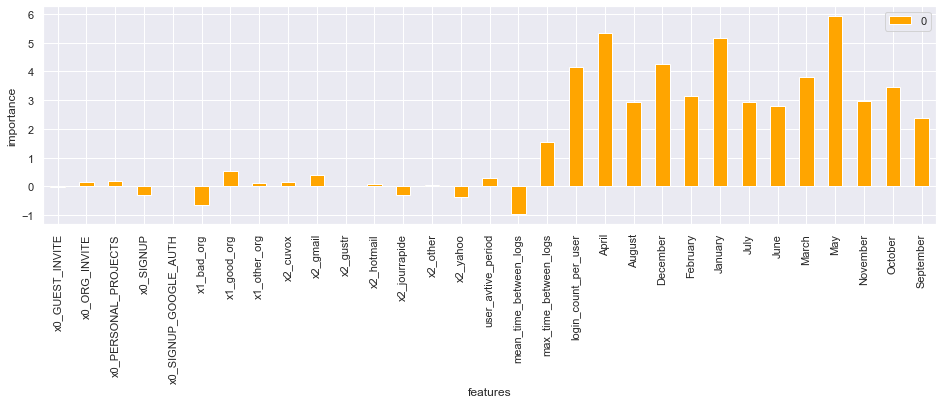

In [738]:
lr_feature_names = list(lr_grid.best_estimator_.named_steps.transform.named_transformers_.ohe.get_feature_names())+list(num_cols)
lr_feature_importance=pd.DataFrame(lr_grid.best_estimator_.named_steps.lr.coef_[0].tolist(), index=lr_feature_names)
lr_feature_importance.plot(kind='bar', figsize=(16,4),color='orange')
plt.xlabel('features')
plt.ylabel('importance')

In [722]:
pred_lr = lr_grid.predict(X_test)
print(confusion_matrix(y_test, pred_lr))

[[2099   37]
 [  26  485]]


In [725]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2136
           1       0.93      0.95      0.94       511

    accuracy                           0.98      2647
   macro avg       0.96      0.97      0.96      2647
weighted avg       0.98      0.98      0.98      2647



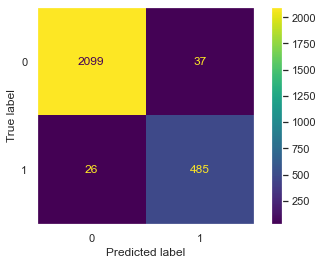

In [724]:
plot_confusion_matrix(lr_grid, X_test, y_test)
plt.grid(False)